## Prerequisites
Importing necessary libraries.

In [1]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import base64
import json

## Original Size Image from Thumbnail
This function takes a thumbnail URL and constructs the corresponding URL for the original image with high resolution.

In [2]:
def construct_image_url(thumbnail_url):
    # Houzz's CDN URL, Images folder.
    url = 'https://st.hzcdn.com/simgs/'

    # Computing the respective indices containing the product_id
    # for products from thumbnail URL and extract product_id.
    start_index = thumbnail_url.find('fimgs') + 6
    end_index = thumbnail_url.find('_', start_index)
    product_id = thumbnail_url[start_index: end_index]

    # Computing the respective indices containing the image_id
    # for images from thumbnail URL and extract image_id.
    start_index = end_index + 1
    end_index = thumbnail_url.find('-', start_index)
    image_id = thumbnail_url[start_index:end_index]

    # Constructing the image URL from the extracted IDs.
    url = url + product_id + '_' + '9-' + image_id + '/home-design.jpg'
    
    return url

## Scrape the Data for a given Product
This function scrapes the desired information from the page that contains the product details and description.

In [3]:
def scrape(product_page_url):
    # Establishing a session.
    s = requests.Session()

    # Fetching the HTML content of the URL.
    page = s.get(product_page_url)

    # Instanciating a BeautifulSoup parser object.
    soup = BeautifulSoup(page.content, 'html.parser')

    # Extracting the product name.
    product_name = soup.find('span', class_='view-product-title').getText()
    # Extracting the product keywords from the
    # "This Product Has Been Described As" section.
    keywords = [keyword.getText() for keyword in soup.find('section', class_='product-keywords ').find_all('li', class_='product-keywords__word')]
    # Extracting every image from the photo album navigation bar.
    images = soup.find_all('div', class_='alt-images__thumb')
    image_list = []
    # Iterating through the images to fetch the original high-resolution
    # photo for the top two images, subject to existence.
    for image in images[:2]:
        # Computing the URL for the original image.
        image_url = construct_image_url(image.find('img')['src'])
        # Fetching the image.
        response = requests.get(image_url)
        # Encoding the image into Base64 format, then decoding it into UTF-8, so that
        # it can placed inside a JSON object, and finally, adding it to the list.
        image_list.append(base64.encodebytes(response.content).decode('utf-8'))
    
    # Inserting data into dictionary, so that it can be parsed into JSON object.
    data = {}
    data['name'] = product_name
    data['keywords'] = keywords
    data['images'] = image_list
    return data

## Scrape a Page of Products
Scrape the page to extract products listed on the page, and then calling the `scrape` function to scrape each product's information.


In [4]:
def scrape_page(page_url, out):
    # Fetching HTML content of the respective page.
    page = requests.get(page_url)

    # Instanciating a BeautifulSoup parser object.
    soup = BeautifulSoup(page.content, 'html.parser')

    # Extracting the product cards.
    elements = soup.find_all('a', class_='hz-product-card__link')

    # Set a counter to keep track of number of elements.
    count = 0
    # Iterating through the elements/cards for scraping.
    for element in elements:
        try:
            # Extracting the page URL from the hyper-reference parameter.
            product_page_url = element['href']
            # Scraping the product data and storing it in JSON format.
            out.write(json.dumps(scrape(product_page_url)) + '\n')
            # Increasing the counter.
            count += 1
        except:
            pass

    # Returning the total number of scraped products.
    return count

## Scrape the Data for a designated Category
This function scrapes the data for at least `item_min` products from a given category.

In [5]:
def scrape_category(category, item_per_page, item_min):
    # First page URL is different from others.
    initial_url = 'https://www.houzz.com/products/' + category

    # Composing a file to save the JSON objects.
    output_file = open(category + '.json', 'w')

    # Setting the counter to zero. The counter is to be used for
    # keeping track of the total number of products scraped, so that
    # it can be checked whether it has surpassed the desired minimum. 
    count = 0
    # Scrape the first page and update the counter.
    count += scrape_page(initial_url, output_file)
    # Setting the page_number to keep track of the number of scraped pages.
    page_number = 1
    # Scraping more pages until at least, item_min products have been indexed.
    while(count < item_min):
        # Computing the page URL (expect for the first page).
        generic_url = 'https://www.houzz.com/products/' + category + '/p/' + str(page_number * item_per_page)
        # Updating the counter.
        count += scrape_page(generic_url, output_file)
        # Increasing the page_number.
        page_number += 1

    # Closing the output file.
    output_file.close()

## Driver Code
Default Values:
+ Minimum number of products to be indexed: $50$
+ Items per Page: $36$

### Category of $Desks$

In [6]:
scrape_category('desks', 36, 50)

### Category of $Chairs$

In [7]:
scrape_category('chairs', 36, 50)

### Category of $Beds$

In [8]:
scrape_category('beds', 36, 50)

### Category of $Sofas$ and $Sectionals$

In [9]:
scrape_category('sofas-and-sectionals', 36, 50)

#### Appendix
To retrieve the images from the JSON files, they have to be encoded into `UTF-8` format and then, decoded from `base64` format into byte-stream.

In [10]:
def display_image_from_json(file_path, index):
    # Input JSON file.
    input_file = open(file_path, 'r', encoding='utf-8')

    # Displaying the images for the item at the "index",
    # without having to go through the entire file.
    for i, line in enumerate(input_file):
        if i == index:
            # Parsing string into JSON object.
            element = json.loads(line)
            # Calling display() function from "PIL".
            for image in element['images']:
                display(Image.open(BytesIO(base64.decodebytes(image.encode('utf-8')))))
        elif i > index:
            break
    
    # Closing the input file.
    input_file.close()

##### Example
Displaying the images of the $Bed$ #$22$.

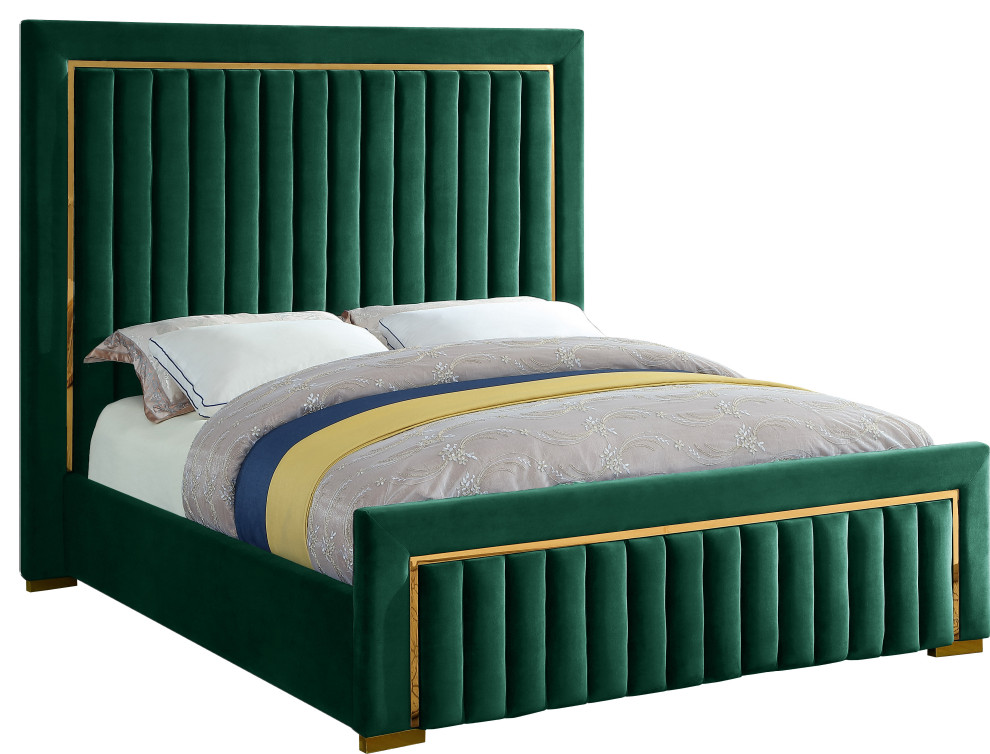

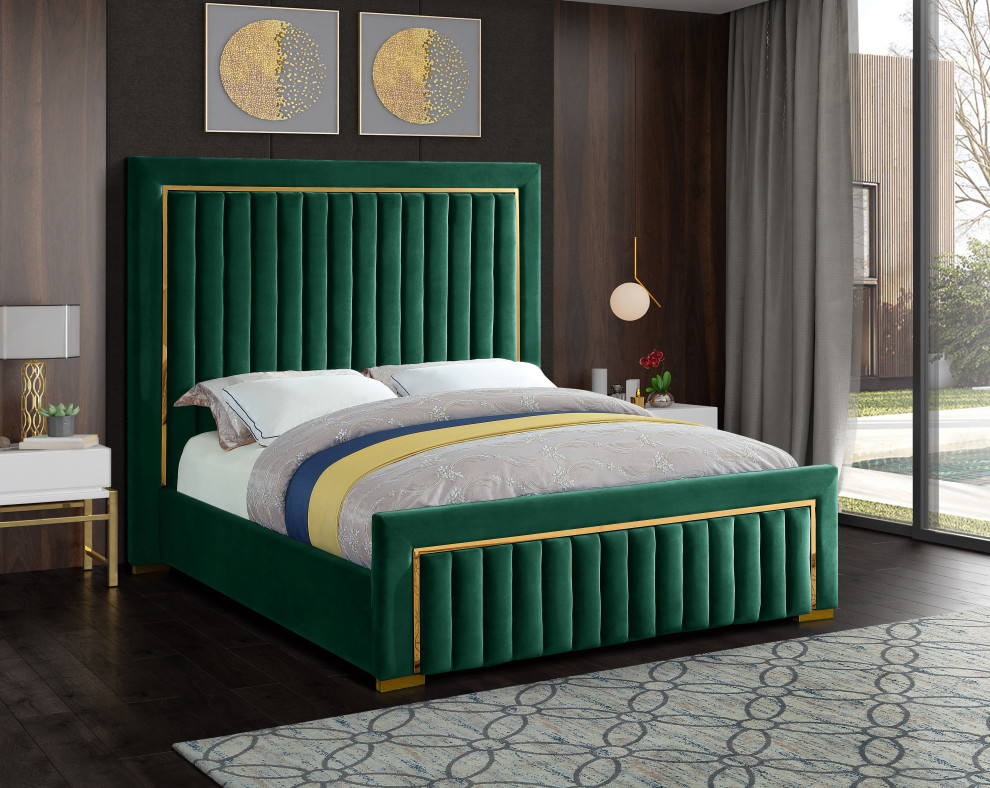

In [11]:
display_image_from_json('beds.json', 22)